In [16]:
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint
from random import seed,random
import plotly.express as px
from IPython.display import display
from pandas import DataFrame
from sklearn.cluster import KMeans

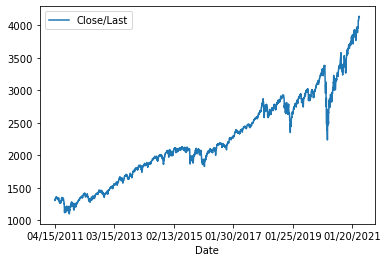

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

spx_short = pd.read_csv('../data/spx_daily_11-21.csv', usecols=[0,1])
spx_short['Close/Last']=spx_short['Close/Last'].astype(int)
spx_short=spx_short.iloc[::-1]
spx_short.plot(x='Date', y='Close/Last')
plt.show()

np_spx_short = spx_short['Close/Last'].to_numpy()

In [18]:
def create_random_walk(ts: np.array):
    """

    :param ts:
    :return:
    """
    ma = np.amax(ts)
    mi = np.amin(ts)
    seed(randint(mi,ma))
    random_walk = list()

    random_walk.append(randint(mi,ma))
    for i in range(1, ts.shape[0]):
	    r = randint(0,9)
	    movement = r if random() < 0.5 else -r
	    value = random_walk[i-1] + movement
	    random_walk.append(value)

    return np.array(random_walk)

In [19]:
def to_sts_matrix(ts: np.array, w: int):
    shape = ts.shape[:-1] + (ts.shape[-1] - w + 1, w)
    strides = ts.strides + (ts.strides[-1],)
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)


def to_random_sampling_matrix(ts: np.array, w: int):
    m = ts.shape[0]
    data_matrix = np.zeros((m - w + 1, w), dtype=int)

    for i in range(m - w + 1):
        r = randint(0, m - w)
        for j in range(w):
            data_matrix[i][j] = ts[r+j]

    return data_matrix

In [20]:
def euclidean_cluster_distance(a: np.array, b: np.array):
    """

    :param a: cluster centres derived from one run of clustering algor (shape: [k,w])
    :param b: cluster centres derived from different run of clustering algor (shape: [k,w])
    :return:
    """
    assert a.shape[1] != 0
    summ = 0
    n = a.shape[0]
    # for i in range(n):
    #     f = lambda x: np.linalg.norm(a[i]-x)
    #     summ += np.amin(f(b))

    # for i in range(n):
    #     minn = float('inf')
    #     for j in range(n):
    #         d = np.linalg.norm(a[i]-b[j])
    #         if d < minn:
    #             minn = d
    #     summ += minn

    for i in range(n):
        f = lambda x: np.linalg.norm(a[i]-x)
        summ += np.amin(np.array(list(map(f,b))))

    # for i in range(n):
    #     f = lambda x: np.linalg.norm(a[i]-x)
    #     vfunc = np.vectorize(f)
    #     print(vfunc(b))
    #     summ += np.amin(vfunc(b))

    return summ


def within_set_distance(x: np.array):
    """

    :param x: set of cluster centers (shape: [n,k,w])
    :return:
    """
    n = x.shape[0]
    summ = 0
    for i in range(n):
        for j in range(n):
            summ += euclidean_cluster_distance(x[i], x[j])
    return summ/n**2


def between_set_distance(x: np.array, y: np.array):
    """

    :param x:
    :param y:
    :return:
    """
    n = x.shape[0]
    m = y.shape[0]
    summ = 0
    for i in range(n):
        for j in range(m):
            summ += euclidean_cluster_distance(x[i], y[j])
    return summ/(n*m)


def clustering_meaningfulness(x: np.array, y: np.array):
    """

    :param x:
    :param y:
    :return:
    """
    return within_set_distance(x)/between_set_distance(x,y)

In [21]:
def calculate_kmeans_meaningfulness(ts: np.array, random_walk: np.array, n: int, k: int, w: int, r: int):
    """

    :param random_walk:
    :param ts:
    :param n:
    :param k:
    :param w:
    :param r:
    :return:
    """
    normalizer = "min-max"
    meaningfulness_sts = 0
    meaningfulness_whole = 0

    sts_ts_matrix = to_sts_matrix(ts, w)
    sts_ts_matrix = scale_feature_matrix(sts_ts_matrix, normalizer)

    whole_ts_matrix = to_random_sampling_matrix(ts, w)
    whole_ts_matrix = scale_feature_matrix(whole_ts_matrix, normalizer)

    sts_random_matrix = to_sts_matrix(random_walk, w)
    sts_random_matrix = scale_feature_matrix(sts_random_matrix, normalizer)

    whole_random_matrix = to_random_sampling_matrix(random_walk, w)
    whole_random_matrix = scale_feature_matrix(whole_random_matrix, normalizer)

    for z in range(n):
        sts_ts_kmeans_centers = np.zeros((r,k,w))
        whole_ts_kmeans_centers = np.zeros((r,k,w))
        sts_random_kmeans_centers = np.zeros((r,k,w))
        whole_random_kmeans_centers = np.zeros((r,k,w))

        for i in range(r):
            sts_ts_kmeans_centers[i] = KMeans(n_clusters=k).fit(sts_ts_matrix).cluster_centers_
            whole_ts_kmeans_centers[i] = KMeans(n_clusters=k).fit(whole_ts_matrix).cluster_centers_
            sts_random_kmeans_centers[i] = KMeans(n_clusters=k).fit(sts_random_matrix).cluster_centers_
            whole_random_kmeans_centers[i] = KMeans(n_clusters=k).fit(whole_random_matrix).cluster_centers_

        meaningfulness_sts += clustering_meaningfulness(sts_ts_kmeans_centers, sts_random_kmeans_centers)
        meaningfulness_whole += clustering_meaningfulness(whole_ts_kmeans_centers, whole_random_kmeans_centers)

    return meaningfulness_sts/n, meaningfulness_whole/n

In [22]:
def scale_feature_matrix(m: np.array, typ="none"):
    if typ == "none":
        return m
    if typ == "snd":
        scaler = StandardScaler()
        return scaler.fit_transform(m)
    if typ == "min-max":
        scaler = MinMaxScaler()
        return scaler.fit_transform(m)

In [23]:
n = 1
r = 3
ks = np.array([3,5,7,11])
ws = np.array([8,16,32])

meaningfulness_sts = []
meaningfulness_whole = []
random_walk = create_random_walk(np_spx_short)

print("n: "+str(n)+", r: "+str(r))
for k in ks:
    for w in ws:
        sts,whole = calculate_kmeans_meaningfulness(ts=np_spx_short, random_walk=random_walk, n=n, k=k, w=w, r=r)
        meaningfulness_sts.append([w,k,sts])
        meaningfulness_whole.append([w,k,whole])
        print("k="+str(k)+", w="+str(w)+" -- STS: "+str(sts)+", Whole: "+str(whole)+"")

df_sts = pd.DataFrame(meaningfulness_sts, columns=['window_size','k','meaningfulness_sts'])
df_whole = pd.DataFrame(meaningfulness_whole, columns=['window_size','k','meaningfulness_whole'])

join_keys = ['window_size','k']
df_meaningfulness = pd.merge(left=df_sts, right=df_whole, right_on=join_keys, left_on=join_keys)
display(df_meaningfulness)

df = df_meaningfulness.melt(id_vars=['window_size', 'k'])
px.bar(df, x='k', y='value', color='variable', barmode='group', facet_col='window_size')



n: 1, r: 3
k=3, w=8 -- STS: 0.0004905844177480197, Whole: 2.34121201270088e-16
k=3, w=16 -- STS: 1.3118584586166648e-16, Whole: 1.7909210658595686e-16
k=3, w=32 -- STS: 2.8232526862436354e-17, Whole: 2.561768782072539e-16
k=5, w=8 -- STS: 0.007006813965215076, Whole: 3.455583535198077e-16
k=5, w=16 -- STS: 3.5421260814129754e-16, Whole: 1.320127767159035e-15
k=5, w=32 -- STS: 0.015227433918059273, Whole: 9.389431936662997e-16
k=7, w=8 -- STS: 1.1017084620864088e-16, Whole: 0.002699241484867289
k=7, w=16 -- STS: 0.003255994782843494, Whole: 8.762364298402963e-16
k=7, w=32 -- STS: 0.0065349357726183725, Whole: 9.620153880235929e-16
k=11, w=8 -- STS: 0.041143083972746734, Whole: 0.11353324105912092
k=11, w=16 -- STS: 0.010874498934546018, Whole: 0.10847061882742336
k=11, w=32 -- STS: 0.01032492279437296, Whole: 0.05158463624378459


,window_size,k,meaningfulness_sts,meaningfulness_whole
0,8,3,4.905844e-04,2.341212e-16
1,16,3,1.311858e-16,1.790921e-16
2,32,3,2.823253e-17,2.561769e-16
3,8,5,7.006814e-03,3.455584e-16
4,16,5,3.542126e-16,1.320128e-15
5,32,5,1.522743e-02,9.389432e-16
6,8,7,1.101708e-16,2.699241e-03
7,16,7,3.255995e-03,8.762364e-16
8,32,7,6.534936e-03,9.620154e-16
9,8,11,4.114308e-02,1.135332e-01
